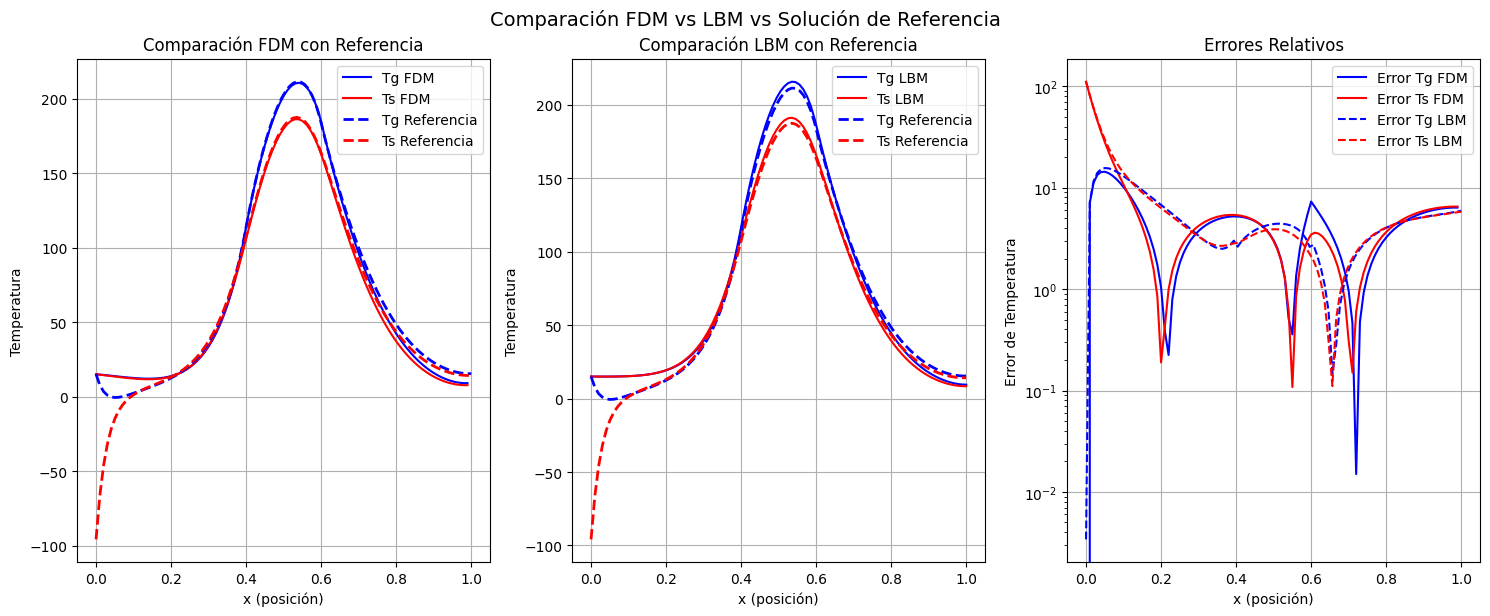

Error medio relativo FDM: 8.18e+00, Ts: 7.46e-01
Error medio relativo LBM: 9.33e+00, Ts: 9.22e-01


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parámetros (consistentes con los códigos C++)
N = 100
dx = 0.01
x = np.linspace(0, 1, N)
alpha_g = 0.01
alpha_s = 0.005
u = 0.1
hv = 5.0
T_in = 15.0
S_value = 315.0

# Definir término fuente
def S(x):
    return np.where((x >= 0.4) & (x <= 0.6), S_value, 0.0)

# Función para el sistema de EDOs (CORREGIDA)
def heat_eqns(t, y):
    # Separar Tg y Ts del vector y
    Tg = y[:N]
    Ts = y[N:]
    
    # Inicializar derivadas
    dTgdt = np.zeros_like(Tg)
    dTsdt = np.zeros_like(Ts)
    
    # Convección (upwind para Tg)
    dTgdt[1:] = -u * (Tg[1:] - Tg[:-1]) / dx
    
    # Difusión (centrada de segundo orden)
    # Tg
    dTgdt[1:-1] += alpha_g * (Tg[2:] - 2*Tg[1:-1] + Tg[:-2]) / dx**2
    # Ts
    dTsdt[1:-1] += alpha_s * (Ts[2:] - 2*Ts[1:-1] + Ts[:-2]) / dx**2
    
    # Acoplamiento y fuente (para todos los puntos internos)
    dTgdt += -hv*(Tg - Ts) + S(x)
    dTsdt += hv*(Tg - Ts)
    
    # Condiciones de contorno
    # Entrada (x=0) - Dirichlet
    dTgdt[0] = Tg[0] - T_in  # Forzar temperatura de entrada
    dTsdt[0] = Ts[0] - T_in
    
    # Salida (x=1) - Neumann cero
    dTgdt[-1] = dTgdt[-2]
    dTsdt[-1] = dTsdt[-2]
    
    return np.concatenate((dTgdt, dTsdt))

# Condiciones iniciales
y0 = np.zeros(2*N)
y0[:N] = T_in  # Temperatura inicial igual a la de entrada

# Resolver el sistema (CORREGIDO - sin vectorized=True)
sol = solve_ivp(heat_eqns, [0, 2.0], y0, method='BDF', t_eval=[2.0], 
                rtol=1e-6, atol=1e-8)

# Extraer solución final
Tg_ref = sol.y[:N, -1]
Ts_ref = sol.y[N:, -1]

# Leer archivos CSV de FDM y LBM
fdm_data = pd.read_csv("fdm_output.csv")
lbm_data = pd.read_csv("lbm_output.csv")

# Crear figura comparativa
plt.figure(figsize=(15, 6))

# Subgráfico para FDM
plt.subplot(1, 3, 1)
plt.plot(fdm_data['x'], fdm_data['Tg'], 'b-', label='Tg FDM')
plt.plot(fdm_data['x'], fdm_data['Ts'], 'r-', label='Ts FDM')
plt.plot(x, Tg_ref, 'b--', linewidth=2, label='Tg Referencia')
plt.plot(x, Ts_ref, 'r--', linewidth=2, label='Ts Referencia')
plt.title("Comparación FDM con Referencia")
plt.xlabel("x (posición)")
plt.ylabel("Temperatura")
plt.legend()
plt.grid(True)

# Subgráfico para LBM
plt.subplot(1, 3, 2)
plt.plot(lbm_data['x'], lbm_data['Tg'], 'b-', label='Tg LBM')
plt.plot(lbm_data['x'], lbm_data['Ts'], 'r-', label='Ts LBM')
plt.plot(x, Tg_ref, 'b--', linewidth=2, label='Tg Referencia')
plt.plot(x, Ts_ref, 'r--', linewidth=2, label='Ts Referencia')
plt.title("Comparación LBM con Referencia")
plt.xlabel("x (posición)")
plt.ylabel("Temperatura")
plt.legend()
plt.grid(True)

# Subgráfico de errores
plt.subplot(1, 3, 3)
plt.plot(fdm_data['x'], np.abs(fdm_data['Tg']-Tg_ref), 'b-', label='Error Tg FDM')
plt.plot(fdm_data['x'], np.abs(fdm_data['Ts']-Ts_ref), 'r-', label='Error Ts FDM')
plt.plot(lbm_data['x'], np.abs(lbm_data['Tg']-Tg_ref), 'b--', label='Error Tg LBM')
plt.plot(lbm_data['x'], np.abs(lbm_data['Ts']-Ts_ref), 'r--', label='Error Ts LBM')
plt.title("Errores Relativos")
plt.xlabel("x (posición)")
plt.ylabel("Error de Temperatura")
plt.legend()
plt.grid(True)
plt.yscale('log')

# Ajustes finales
plt.tight_layout()
plt.suptitle("Comparación FDM vs LBM vs Solución de Referencia", y=1.02, fontsize=14)
plt.show()

# Calcular errores globales
error_Tg_fdm = np.mean(np.abs(fdm_data['Tg']-Tg_ref)/np.abs(Tg_ref))
error_Ts_fdm = np.mean(np.abs(fdm_data['Ts']-Ts_ref)/np.abs(Ts_ref))
error_Tg_lbm = np.mean(np.abs(lbm_data['Tg']-Tg_ref)/np.abs(Tg_ref))
error_Ts_lbm = np.mean(np.abs(lbm_data['Ts']-Ts_ref)/np.abs(Ts_ref))

print(f"Error medio relativo FDM: {error_Tg_fdm:.2e}, Ts: {error_Ts_fdm:.2e}")
print(f"Error medio relativo LBM: {error_Tg_lbm:.2e}, Ts: {error_Ts_lbm:.2e}")

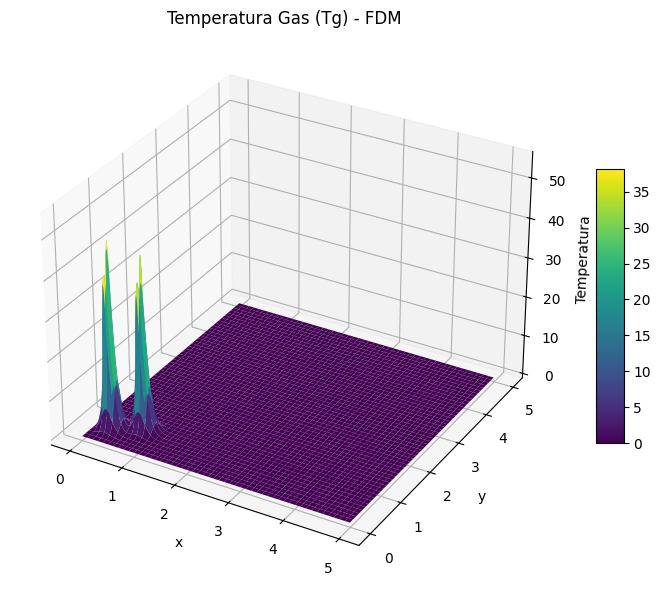

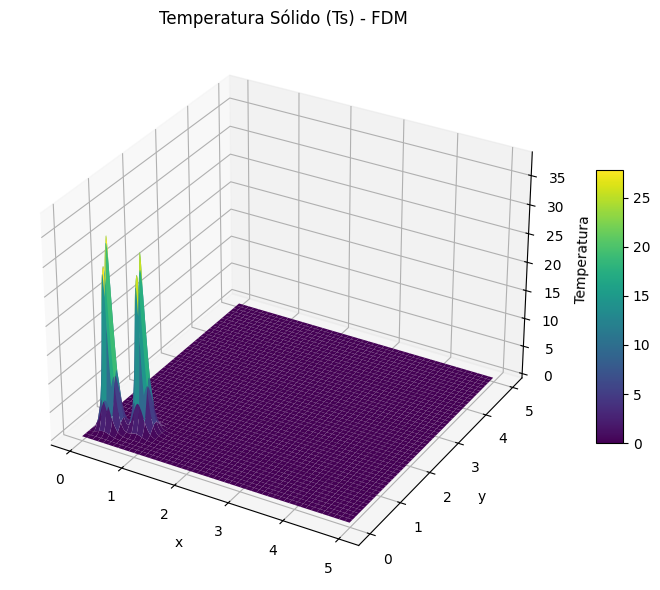

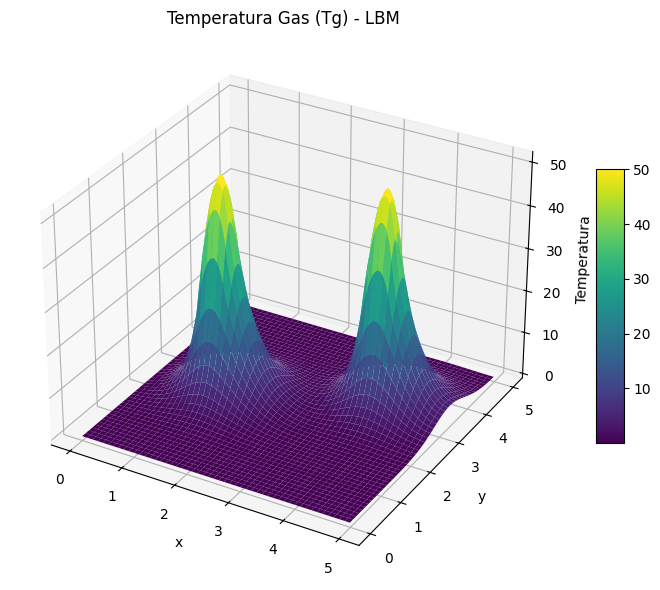

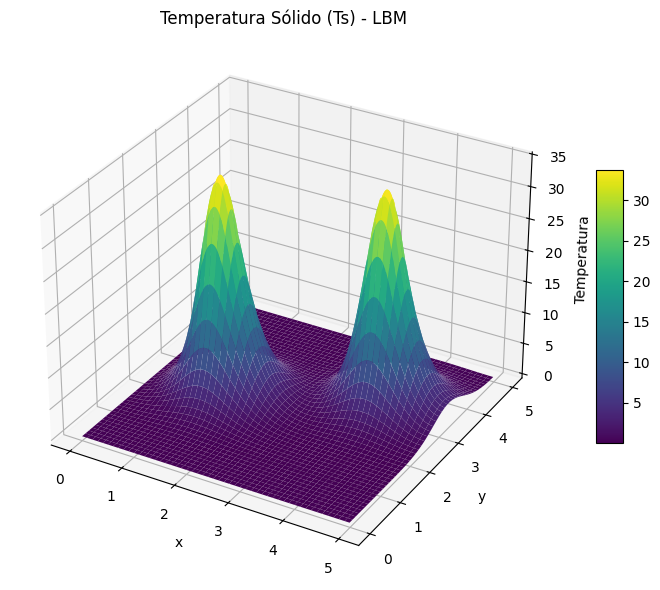

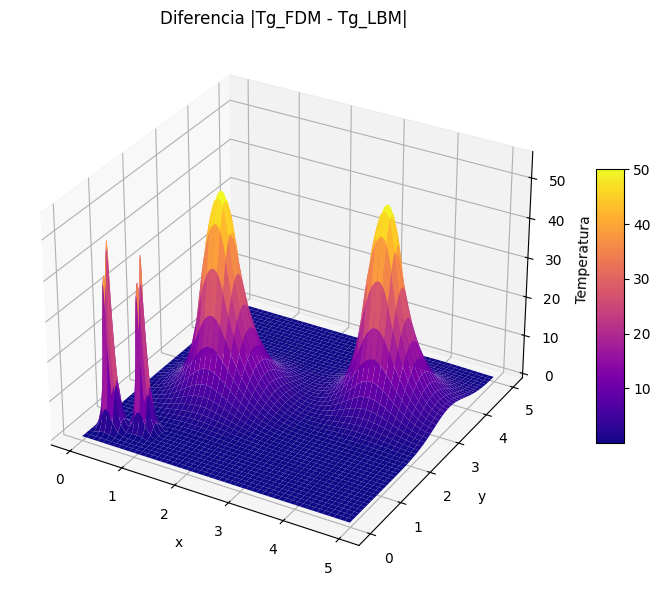

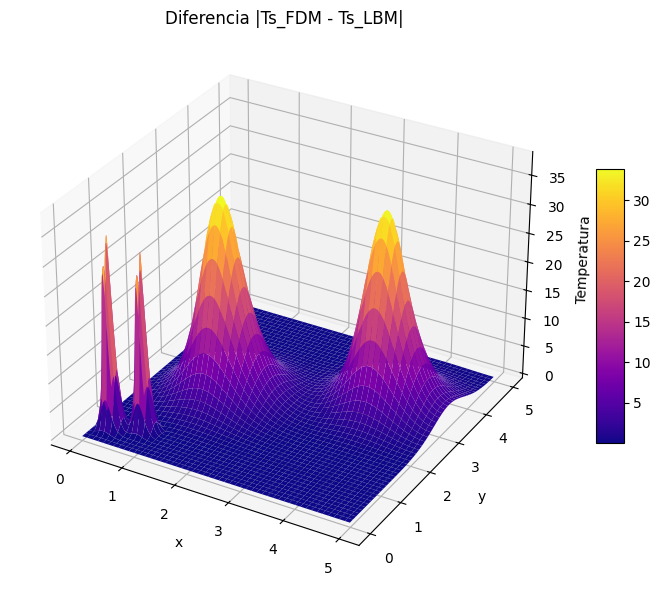

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Configuración
Nx = 1000
Ny = 1000
dx = 0.01
dy = 0.01

# Leer archivos
fdm_data = pd.read_csv("fdm2d_output.csv")
lbm_data = pd.read_csv("lbm2d_output.csv")

# Crear grillas
x = np.linspace(0, dx * (Nx - 1), Nx)
y = np.linspace(0, dy * (Ny - 1), Ny)
X, Y = np.meshgrid(x, y)

# Función auxiliar para reorganizar los datos planos en grillas 2D
def reshape_field(data, field):
    return data[field].values.reshape((Nx, Ny)).T  # Transponer para que (x,y) esté alineado

# Extraer campos de FDM
Tg_fdm = reshape_field(fdm_data, 'Tg')
Ts_fdm = reshape_field(fdm_data, 'Ts')

# Extraer campos de LBM
Tg_lbm = reshape_field(lbm_data, 'Tg')
Ts_lbm = reshape_field(lbm_data, 'Ts')

# Función de graficado 3D
def plot_surface(X, Y, Z, title, cmap='viridis'):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap=cmap, edgecolor='none')
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('Temperatura')
    fig.colorbar(surf, shrink=0.5, aspect=10)
    plt.tight_layout()
    plt.show()

# Mostrar resultados FDM
plot_surface(X, Y, Tg_fdm, "Temperatura Gas (Tg) - FDM")
plot_surface(X, Y, Ts_fdm, "Temperatura Sólido (Ts) - FDM")

# Mostrar resultados LBM
plot_surface(X, Y, Tg_lbm, "Temperatura Gas (Tg) - LBM")
plot_surface(X, Y, Ts_lbm, "Temperatura Sólido (Ts) - LBM")

# Mostrar diferencia
plot_surface(X, Y, np.abs(Tg_fdm - Tg_lbm), "Diferencia |Tg_FDM - Tg_LBM|", cmap='plasma')
plot_surface(X, Y, np.abs(Ts_fdm - Ts_lbm), "Diferencia |Ts_FDM - Ts_LBM|", cmap='plasma')


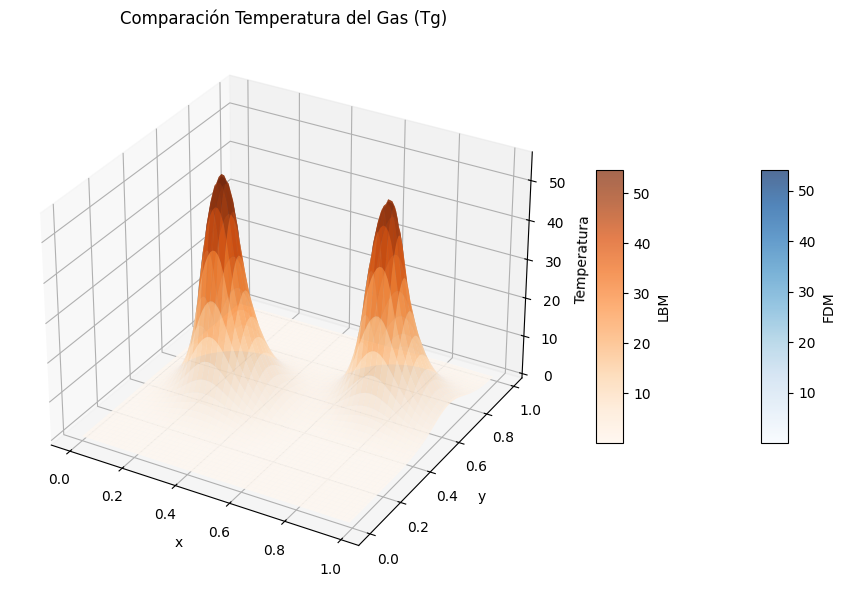

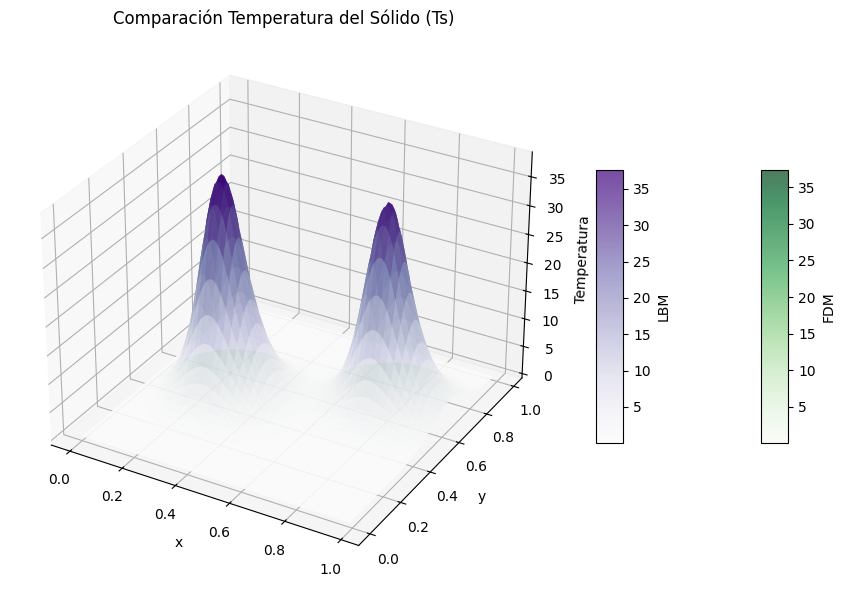

Error relativo medio Tg: 1.23e-01
Error relativo medio Ts: 2.35e-01


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configuración
Nx = 100
Ny = 100
dx = 0.01
dy = 0.01

# Leer archivos CSV
fdm_data = pd.read_csv("fdm2d_output.csv")
lbm_data = pd.read_csv("lbm2d_output.csv")

# Crear malla (grilla) para visualización
x = np.linspace(0, dx * (Nx - 1), Nx)
y = np.linspace(0, dy * (Ny - 1), Ny)
X, Y = np.meshgrid(x, y)

# Reorganizar datos planos en grillas 2D
def reshape_field(data, field):
    return data[field].values.reshape((Nx, Ny)).T

# Extraer campos
Tg_fdm = reshape_field(fdm_data, 'Tg')
Ts_fdm = reshape_field(fdm_data, 'Ts')
Tg_lbm = reshape_field(lbm_data, 'Tg')
Ts_lbm = reshape_field(lbm_data, 'Ts')

# === GRAFICAR Tg ===
fig1 = plt.figure(figsize=(10, 6))
ax1 = fig1.add_subplot(111, projection='3d')
surf1 = ax1.plot_surface(X, Y, Tg_fdm, cmap='Blues', alpha=0.7, label='FDM')
surf2 = ax1.plot_surface(X, Y, Tg_lbm, cmap='Oranges', alpha=0.7, label='LBM')
ax1.set_title("Comparación Temperatura del Gas (Tg)")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("Temperatura")
fig1.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10, label='FDM')
fig1.colorbar(surf2, ax=ax1, shrink=0.5, aspect=10, label='LBM')
plt.tight_layout()
plt.show()

# === GRAFICAR Ts ===
fig2 = plt.figure(figsize=(10, 6))
ax2 = fig2.add_subplot(111, projection='3d')
surf3 = ax2.plot_surface(X, Y, Ts_fdm, cmap='Greens', alpha=0.7, label='FDM')
surf4 = ax2.plot_surface(X, Y, Ts_lbm, cmap='Purples', alpha=0.7, label='LBM')
ax2.set_title("Comparación Temperatura del Sólido (Ts)")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("Temperatura")
fig2.colorbar(surf3, ax=ax2, shrink=0.5, aspect=10, label='FDM')
fig2.colorbar(surf4, ax=ax2, shrink=0.5, aspect=10, label='LBM')
plt.tight_layout()
plt.show()

# === ERRORES RELATIVOS ===
def relative_error(fdm, lbm):
    # Evita división por cero
    denominator = np.where(np.abs(fdm) > 1e-8, np.abs(fdm), 1.0)
    return np.abs(fdm - lbm) / denominator

rel_err_Tg = relative_error(Tg_fdm, Tg_lbm)
rel_err_Ts = relative_error(Ts_fdm, Ts_lbm)

print(f"Error relativo medio Tg: {np.mean(rel_err_Tg):.2e}")
print(f"Error relativo medio Ts: {np.mean(rel_err_Ts):.2e}")


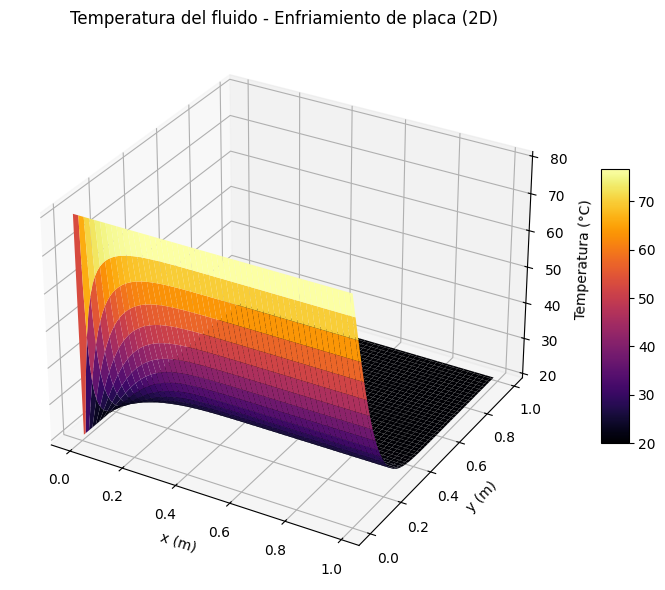

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Configuración
Nx = 100
Ny = 100
dx = 0.01
dy = 0.01

# Leer archivo
data = pd.read_csv("cooling2d_output.csv")

# Crear grillas
x = np.linspace(0, dx * (Nx - 1), Nx)
y = np.linspace(0, dy * (Ny - 1), Ny)
X, Y = np.meshgrid(x, y)

# Reorganizar campo T en forma de malla
def reshape_field(data, field):
    return data[field].values.reshape((Nx, Ny)).T  # Transponer para que X y Y coincidan con la malla

# Extraer campo de temperatura
T = reshape_field(data, 'T')

# Graficar superficie 3D
def plot_surface(X, Y, Z, title, cmap='inferno'):
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap=cmap, edgecolor='none')
    ax.set_title(title)
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_zlabel('Temperatura (°C)')
    fig.colorbar(surf, shrink=0.5, aspect=10)
    plt.tight_layout()
    plt.show()

# Mostrar resultado
plot_surface(X, Y, T, "Temperatura del fluido - Enfriamiento de placa (2D)")